# Analysis Notebook for CurioTower experiment

(Need to add link to pre-registration)

The goal of this experiment is to gather human judgments on the "interestingness" and "stability" of towers, both generated in curiodrop and TDW

### Establish connection to mongo
First thing you need to do is to establish an ssh tunnel (aka remote port forwarding) to the server, so that requests to the mongodb can be made "as if" the mongodb server is running on your local computer. Run this from the command line before you begin data analysis if you plan to fetch data from mongo:

`ssh -fNL 27017:127.0.0.1:27017 USERNAME@cogtoolslab.org`

### Load packages

In [1]:
import os
import sys
import urllib, io
os.getcwd()
sys.path.append("..")
sys.path.append("../utils")
sys.path.append("../analysis/utils")


import numpy as np
import scipy.stats as stats
import pandas as pd

import pymongo as pm
from collections import Counter
import json
import re
import ast

from PIL import Image, ImageOps, ImageDraw, ImageFont 

from io import BytesIO
import base64

import  matplotlib
from matplotlib import pylab, mlab, pyplot
%matplotlib inline
from IPython.core.pylabtools import figsize, getfigs
plt = pyplot
import matplotlib as mpl
mpl.rcParams['pdf.fonttype'] = 42

import seaborn as sns
sns.set_context('talk')
sns.set_style('darkgrid')

from IPython.display import clear_output

import warnings
warnings.filterwarnings("ignore", category=DeprecationWarning)
warnings.filterwarnings("ignore", message="numpy.dtype size changed")
warnings.filterwarnings("ignore", message="numpy.ufunc size changed")

# import drawing_utils as drawing
# import importlib
# import scoring

### Set up directory paths to plots and data

In [2]:
## directory & file hierarchy
proj_dir = os.path.abspath('..')
datavol_dir = os.path.join(proj_dir,'data')
analysis_dir =  os.path.abspath('.')
results_dir = os.path.join(proj_dir,'results')
plot_dir = os.path.join(results_dir,'plots')
csv_dir = os.path.join(results_dir,'csv')
json_dir = os.path.join(results_dir,'json')
exp_dir = os.path.abspath(os.path.join(proj_dir,'behavioral_experiments'))
png_dir = os.path.abspath(os.path.join(datavol_dir,'png'))

## add helpers to python path
if os.path.join(proj_dir,'stimuli') not in sys.path:
    sys.path.append(os.path.join(proj_dir,'stimuli'))
    
if not os.path.exists(results_dir):
    os.makedirs(results_dir)
    
if not os.path.exists(plot_dir):
    os.makedirs(plot_dir)   
    
if not os.path.exists(csv_dir):
    os.makedirs(csv_dir)       
    
## add helpers to python path
if os.path.join(proj_dir,'utils') not in sys.path:
    sys.path.append(os.path.join(proj_dir,'utils'))   

def make_dir_if_not_exists(dir_name):   
    if not os.path.exists(dir_name):
        os.makedirs(dir_name)
    return dir_name

## create directories that don't already exist        
result = [make_dir_if_not_exists(x) for x in [results_dir,plot_dir,csv_dir]]

In [3]:
# set vars 
auth = pd.read_csv(os.path.join(analysis_dir,'auth.txt'), header = None) # this auth.txt file contains the password for the sketchloop user
pswd = auth.values[0][0]
user = 'sketchloop'
host = 'cogtoolslab.org'

# have to fix this to be able to analyze from local
import pymongo as pm
conn = pm.MongoClient('mongodb://sketchloop:' + pswd + '@127.0.0.1')


#### Connect to database

In [4]:
db = conn['curiotower']
coll = db['curiotower_curiodrop']


In [5]:
iterationName = 'testing-new-meta'
coll.distinct('iterationName')

['testing-new-meta']

### Construct tidy dataframe with game data

In [27]:
df = coll.find({
            'iterationName':iterationName
#             'prolificID': {'$exists' : True},
#             'studyID': {'$exists' : True},
#             'sessionID': {'$exists' : True},
#             'eventType': 'rating-task'
})
df = pd.DataFrame(df)


## Inspect dataframe

In [28]:
print(df.shape)
print(df.columns)

(21, 37)
Index(['_id', 'type', 'iterationName', 'numTrials', 'condition', 'prompt',
       'towerID', 'image_url', 'stim_version', 'games', 'trialNum',
       'prolificID', 'studyID', 'sessionID', 'gameID', 'image_html',
       'session_id', 'upper_bound', 'lower_bound', 'choices', 'button_html',
       'message', 'stimulus_duration', 'trial_duration', 'trial_num',
       'margin_vertical', 'margin_horizontal', 'response_ends_trial',
       'reaction_time', 'button_pressed', 'startTrialTime', 'endTrialTime',
       'trial_type', 'trial_index', 'time_elapsed', 'internal_node_id',
       'catch_trial'],
      dtype='object')


In [29]:
df['button_pressed'] = pd.to_numeric(df['button_pressed'])
print(df.shape)
df.tail(10)

(21, 37)


,_id,type,iterationName,numTrials,condition,prompt,towerID,image_url,stim_version,games,...,response_ends_trial,reaction_time,button_pressed,startTrialTime,endTrialTime,trial_type,trial_index,time_elapsed,internal_node_id,catch_trial
11,5fc5a4666ccd8973aec08204,image-button-response,testing-new-meta,6,stable,How stable is this?,121119_09,https://curiotower.s3.amazonaws.com/121119_09.png,curiodrop,[],...,True,1746.255,0,53304.280,1.606788e+12,image-button-response,5,53757,0.0-5.0,False
12,5fc5a46c6ccd8973aec08205,image-button-response,testing-new-meta,6,stable,How stable is this?,catch_01,https://curiotower.s3.amazonaws.com/catch_01.jpg,curiodrop,[],...,True,1300.310,0,59562.060,1.606788e+12,image-button-response,6,59569,0.0-6.0,True
13,5fc5a4716ccd8973aec08206,image-button-response,testing-new-meta,6,stable,How stable is this?,catch_03,https://curiotower.s3.amazonaws.com/catch_03.jpg,curiodrop,[],...,True,630.985,0,65376.915,1.606788e+12,image-button-response,7,64715,0.0-7.0,True
14,5fc5a4776ccd8973aec08207,image-button-response,testing-new-meta,6,stable,How stable is this?,121619_05,https://curiotower.s3.amazonaws.com/121619_05.png,curiodrop,[],...,True,1368.290,4,70512.455,1.606788e+12,image-button-response,8,70588,0.0-8.0,False
15,5fc5a47e6ccd8973aec08208,image-button-response,testing-new-meta,6,stable,How stable is this?,121119_10,https://curiotower.s3.amazonaws.com/121119_10.png,curiodrop,[],...,True,1963.215,4,76389.805,1.606788e+12,image-button-response,9,77060,0.0-9.0,False
16,5fc5a4836ccd8973aec08209,image-button-response,testing-new-meta,6,stable,How stable is this?,121119_10b,https://curiotower.s3.amazonaws.com/121119_10b...,curiodrop,[],...,True,1075.740,3,82864.975,1.606788e+12,image-button-response,10,82648,0.0-10.0,False
17,5fc5c2286ccd8973aec0820a,image-button-response,testing-new-meta,6,interesting,How interesting is this?,121819_05,https://curiotower.s3.amazonaws.com/121819_05.png,curiodrop,[],...,True,2139.870,0,18555.610,1.606796e+12,image-button-response,1,19898,0.0-1.0,False
18,5fc5c22d6ccd8973aec0820b,image-button-response,testing-new-meta,6,interesting,How interesting is this?,121319_01,https://curiotower.s3.amazonaws.com/121319_01.png,curiodrop,[],...,True,1036.460,1,25213.170,1.606796e+12,image-button-response,2,25453,0.0-2.0,False
19,5fc5c2336ccd8973aec0820c,image-button-response,testing-new-meta,6,interesting,How interesting is this?,121619_05,https://curiotower.s3.amazonaws.com/121619_05.png,curiodrop,[],...,True,1258.290,4,30763.445,1.606796e+12,image-button-response,3,31225,0.0-3.0,False
20,5fc5c23a6ccd8973aec0820d,image-button-response,testing-new-meta,6,interesting,How interesting is this?,121619_10,https://curiotower.s3.amazonaws.com/121619_10.png,curiodrop,[],...,True,2848.125,2,36541.890,1.606796e+12,image-button-response,4,38594,0.0-4.0,False


## Include catch-trial checks:

Check whether subjects rated the catch trials as stable <3 or interesting >3. Remove those who fail catch

In [19]:


df_catch = df[df['catch_trial'] == True]

#return array of gameIDs that failed catch trials
failed_catch = df_catch[((df_catch['button_pressed'] <3) & (df_catch['condition'] == 'stable')) |
                       ((df_catch['button_pressed'] >3) & (df_catch['condition'] == 'interesting'))]['gameID'].unique()
failed_catch

array(['1513-3be2f6d4-7fc6-41bd-a0e2-db9e8cbda5ff'], dtype=object)

In [22]:
df = df[~df.gameID.isin(failed_catch)]
df.head(2)

,_id,type,iterationName,numTrials,condition,prompt,towerID,image_url,stim_version,games,...,reaction_time,button_pressed,startTrialTime,endTrialTime,trial_type,trial_index,time_elapsed,internal_node_id,catch_trial,time_on_trial
0,5fb829606ccd8973aec081f9,image-button-response,testing-new-meta,6,stable,How stable is this?,121119_08b,https://curiotower.s3.amazonaws.com/121119_08b...,curiodrop,[],...,450.060,0,15675.225,1.605905e+12,image-button-response,1,15678,0.0-1.0,NaN,2.775
1,5fb829656ccd8973aec081fa,image-button-response,testing-new-meta,6,stable,How stable is this?,121619_09,https://curiotower.s3.amazonaws.com/121619_09.png,curiodrop,[],...,615.995,1,20648.870,1.605905e+12,image-button-response,2,20817,0.0-2.0,NaN,168.130


#### Inspect response distribution

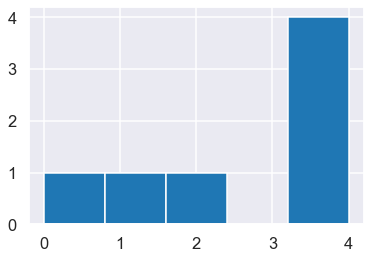

In [23]:
df['button_pressed'].hist(bins = 5)

#### Inspect timing data

In [30]:
df[['startTrialTime','endTrialTime', 'time_elapsed']].tail(10)

,startTrialTime,endTrialTime,time_elapsed
11,53304.280,1.606788e+12,53757
12,59562.060,1.606788e+12,59569
13,65376.915,1.606788e+12,64715
14,70512.455,1.606788e+12,70588
15,76389.805,1.606788e+12,77060
16,82864.975,1.606788e+12,82648
17,18555.610,1.606796e+12,19898
18,25213.170,1.606796e+12,25453
19,30763.445,1.606796e+12,31225
20,36541.890,1.606796e+12,38594


In [32]:
df['time_on_trial'] = df['time_elapsed'] - df['startTrialTime']
df_time = df.groupby(['trial_index'])['time_on_trial'].mean()
df_time


trial_index
1     4102.355000
2       71.733333
3     -146.323333
4      754.826667
5      417.020000
6       47.232500
7     -242.560000
8       75.545000
9      670.195000
10    -216.975000
Name: time_on_trial, dtype: float64

In [37]:
(1606844088425 - 1606843992037)

96388

trial_index
1    1.605905e+12
2    1.605905e+12
3    1.605905e+12
4    1.605905e+12
5    1.605905e+12
6    1.605905e+12
7    1.605905e+12
Name: time_on_trial, dtype: float64

# _______________________________________________________

# After this point is old compabs analysis (saving just in case...)


# ________________________________________________________

In [ ]:
## get list of all gameIDs in database
total_games = coll.find({'iterationName':iterationName}).distinct('gameid')
print('There are {} total games.'.format(len(total_games)))

## get list of complete gameIDs
gameIDs = coll.find({'iterationName':iterationName}).distinct('gameid')
complete_games = [g for g in gameIDs if len(coll.find({'gameid':g}).distinct('trialNum')) == numTrials]
print('There are {} complete games.'.format(len(complete_games)))

In [ ]:
broken_games = []
complete_games = [g for g in complete_games if g not in broken_games]

def construct_tidy_dataframe(eventType = 'chatMessage', 
                             complete_games = [],
                             iterationName = 'pilot1',
                             remove_workerID = True):
    '''
    input: list of complete games and name of event Type
    '''
    event2name = {'chatMessage':'chat', 'block':'block', 'endTrial':'trial', 'exitSurvey':'exit'}
    L = pd.DataFrame()
    for g, this_gameID in enumerate(complete_games):
        print('Analyzing game {} | {} of {}'.format(this_gameID, g+1, len(complete_games)))
        clear_output(wait=True) 

        ### extract records 
        #loop over iteration names??
        X = coll.find({ '$and': [{'iterationName':iterationName}, 
#                                  {"$or":[{'iterationName':'Exp2Pilot3'},
#                                  {'iterationName':'Exp2Pilot3_batch2'}]}
                                 {'gameid': this_gameID}, {'eventType': eventType}]}).sort('time') 
        
        li = list(X)        
        _L = pd.DataFrame(li)  

        ## concat with previous game's dataframe
        if L.shape[0]==0:
            L = _L
        else: 
            L = pd.concat([L,_L], axis=0)     

    ## postprocessing
    if remove_workerID and 'workerId' in L.columns:
        L = L.drop('workerId',axis=1)

    ## save out group dataframe to csv dir
    out_path = os.path.join(csv_dir,'compabs_{}_{}.csv'.format(event2name[eventType],iterationName))
    print('Saving dataframe out to CSV dir at path: {}'.format(out_path))    
    L.to_csv(out_path)             

    return L


In [ ]:
## construct dataframe for each datatype
dataTypes = coll.distinct('eventType')
for thisDataType in dataTypes:
    X = construct_tidy_dataframe(eventType=thisDataType, complete_games=complete_games, iterationName=iterationName)


## Full DF from DB

In [ ]:
# Ensure one to one gameID and workerId 
# Should only happen if a repeat worker gets through

# query = coll.find({"$and":[
# #                         {'workerId':{'$exists':True}},
# #                         {'condition':{'$ne':'practice'}},
# #                         {'eventType':'trial_end'},
#                         {"$or":[{'iterationName':'testing'}]}]
#                      })

#df_trial_end_full = pd.DataFrame(list(query.sort('timeAbsolute')))
#df_trial_end_full[['workerId','gameID']]

query = coll.find()

df_trial_end_full = pd.DataFrame(list(query))

#assert (np.mean(df_trial_end_full['workerId'].value_counts()) == np.mean(df_trial_end_full['gameID'].value_counts()))

In [ ]:
## How many records?
coll.estimated_document_count()

In [ ]:
#df_trial_end_full.columns

#### check outcome for specific workerID

In [ ]:
#set worker ID
workerID = 'A37XBH865833FE'
iteration = 'pilot0'
#get GameID (not all info available at workerID level (e.g. bonus))
gameID = df_trial_end_full[df_trial_end_full['workerId'] == workerID]['gameid'].unique()[0]

#check iteration name
df_game = df_trial_end_full[(df_trial_end_full['iterationName'] == iteration) &
                            (df_trial_end_full['gameid'] == gameID)]
#get workerIds
print('workerIDS:',df_game['workerId'].unique())
#get bonus for gameID ([air of workerIDs])
print("Bonus:",np.nanmax(df_game['cumulativeBonus']))

In [ ]:
df_trial_end_full[(df_trial_end_full['iterationName'] == 'pilot2')].content.unique()

In [ ]:
#see full history for single worker
df_test = df_trial_end_full[(df_trial_end_full['iterationName'] == iterationName)&
                           (df_trial_end_full['workerId'] == workerID)]
df_test.content.unique()

## Trial Level Data

In [ ]:
# # Assuming that if trial 23 saves, then 0-22 have also saved 
# # get ids of people with trial 23 data
# query = coll.find({"$and":[
#                         {'condition':{'$ne':'practice'}},
#                         {'eventType':'trial_end'},
#                         {"$or":[{'iterationName':'Exp2Pilot3'},
#                                 {'iterationName':'Exp2Pilot3_batch2'}]},
#                         #{'iterationName': iterationName}, #use this if one iteration name
#                         {'trialNum': numTrials-1}]
#                      })
# complete_data_df = pd.DataFrame(query)
# complete_data_ids = list(complete_data_df['workerId'])

In [ ]:
# # Filter for full datasets
# query = coll.find({"$and":[
#                         {'condition':{'$ne':'practice'}},
#                         {'eventType':'trial_end'},
#                         #{'iterationName': iterationName}, #use this if one iteration name
#                         {"$or":[{'iterationName':'Exp2Pilot3'},
#                                 {'iterationName':'Exp2Pilot3_batch2'}]}]
#                      })

# df_trial_end_full = pd.DataFrame(list(query.sort('timeAbsolute')))


# # filter dataframe for complete datasets
# df_trial_end_full_filtered = df_trial_end_full[df_trial_end_full.workerId.isin(complete_data_ids)]

# # reduce to crucial information
# df_trial_end_reduced_filtered = df_trial_end_full_filtered[[
#     'gameID','trialNum','phase','condition','eventType','targetName','repetition','targetID', #trial identifiers
#     'nullScore','F1Score','normedScore','rawScoreDiscrete','nullScoreDiscrete','normedScoreDiscrete','scoreGapDiscrete', #scoring
#     'numBlocks','nPracticeAttempts','blockColor','blockColorID','blockFell','doNothingRepeats',#misc. trial info
#     'score','currBonus','timeBonus', #bonusing
#     'timeAbsolute','timeRelative','buildTime','buildStartTime','buildFinishTime','timeToBuild', #timing 
#     'discreteWorld','allVertices', #world reconstruction
#     'browser','browserVersion','os','devMode', #developer info
#     #below here should be the same for every trial in a dataset
#     'iterationName',
#     'numTargets', 'prePostSetSize','numRepetitions', #pre-post info
#     'bonusThresholdLow','bonusThresholdMid','bonusThresholdHigh','timeThresholdYellow','timeThresholdRed', #bonus info
#     ]]

# #Fix error in data-saving- normedScoreDiscrete saved as rawScoreDiscrete
# df_trial_end_reduced_filtered['normedScoreDiscrete'] = df_trial_end_reduced_filtered['rawScoreDiscrete']
# df_trial_end_reduced_filtered.drop(['rawScoreDiscrete'], axis=1)


# df = df_trial_end_reduced_filtered.sort_values(by=['gameID', 'timeAbsolute'])

## Create DF for each event

In [ ]:
#read in dataframes from each eventType
df_block = pd.read_csv('../results/csv/compabs_block_{}.csv'.format(iterationName))
df_chat = pd.read_csv('../results/csv/compabs_chat_{}.csv'.format(iterationName))
df_exit = pd.read_csv('../results/csv/compabs_exit_{}.csv'.format(iterationName))
df_trial = pd.read_csv('../results/csv/compabs_trial_{}.csv'.format(iterationName))

In [ ]:
#manually build full df (needs to be generalized)
df_block0 = pd.read_csv('../results/csv/compabs_block_{}.csv'.format('pilot0'))
df_chat0 = pd.read_csv('../results/csv/compabs_chat_{}.csv'.format('pilot0'))
df_exit0 = pd.read_csv('../results/csv/compabs_exit_{}.csv'.format('pilot0'))
df_trial0 = pd.read_csv('../results/csv/compabs_trial_{}.csv'.format('pilot0'))
#
df_block1 = pd.read_csv('../results/csv/compabs_block_{}.csv'.format('pilot1'))
df_chat1 = pd.read_csv('../results/csv/compabs_chat_{}.csv'.format('pilot1'))
df_exit1 = pd.read_csv('../results/csv/compabs_exit_{}.csv'.format('pilot1'))
df_trial1 = pd.read_csv('../results/csv/compabs_trial_{}.csv'.format('pilot1'))
#
df_block2 = pd.read_csv('../results/csv/compabs_block_{}.csv'.format('pilot2'))
df_chat2 = pd.read_csv('../results/csv/compabs_chat_{}.csv'.format('pilot2'))
df_exit2 = pd.read_csv('../results/csv/compabs_exit_{}.csv'.format('pilot2'))
df_trial2 = pd.read_csv('../results/csv/compabs_trial_{}.csv'.format('pilot2'))

df_block = pd.concat([df_block0,df_block1,df_block2])
df_chat = pd.concat([df_chat0,df_chat1,df_chat2])
df_exit = pd.concat([df_exit0,df_exit1,df_exit2])
df_trial = pd.concat([df_trial0,df_trial1,df_trial2])

print("Total Completed Games:",len(df_exit.gameid.unique()))

#### Exclusion Criteria

In [ ]:
#How many dyads fulfill 75% Accuracy on 75% of trials
df75 = pd.DataFrame(df_trial.groupby(['gameid', 'trialNum'])['trialScore'].sum()>75).groupby(['gameid']).sum()
df75['trials'] = df75['trialScore']
print("Total dyads achieving 75% Accuracy on 75% of trials:",len(df75[df75['trials']>=9]))

In [ ]:
df_exit.confused

In [ ]:
#read in dataframes from each eventType
# block_data = []
# for i in range(0,3):
#     block_data.append(pd.read_csv('../results/csv/compabs_block_pilot{}.csv'.format(i)))
# df_block = pd.concat(block_data)
# df_block =  [pd.merge(pd.read_csv('../results/csv/compabs_block_pilot{}.csv'.format(i))) for i in range(0,3)]
# df_chat = pd.read_csv('../results/csv/compabs_chat_{}.csv'.format(iterationName))
# df_exit = pd.read_csv('../results/csv/compabs_exit_{}.csv'.format(iterationName))
# df_trial = pd.read_csv('../results/csv/compabs_trial_{}.csv'.format(iterationName))

In [ ]:
df_block.iterationName.unique()

In [ ]:
df_exit.comments.unique()

#### Total Game Duration (for Gameplay)

In [ ]:
(df_exit.groupby(['gameid'])['totalLength'].max()/60000).hist()
plt.xlabel("Duration (min)")
plt.show()

In [ ]:
(df_exit.groupby(['gameid'])['totalLength'].max()/60000).mean()

### Inspect some raw data: language

In [ ]:
#create columns for char and word counts
df_chat['word_count'] = df_chat['content'].str.split(' ').str.len()
df_chat['char_count'] = df_chat['content'].str.len()

In [ ]:
#Coerce trialNum to numeric -- will remove "practice". Thoughts?
df_chat['trialNum'] = pd.to_numeric(df_chat['trialNum'], errors = 'coerce')

In [ ]:
#inspect specific chat history of one dyad
dyadGameId = '8548-343a533f-0369-4b20-bbd4-a00f25359cea'
df_chat[(df_chat.gameid == dyadGameId)]['content'].unique()

### Inspect some raw data: display block towers

In [ ]:
importlib.reload(drawing)
df_block['w'] = df_block['width']
df_block['h'] = df_block['height']
floatCols = ['w','h','blockNum','turnNum','x','y']
df_block[floatCols] = df_block[floatCols].applymap(np.int64)

In [ ]:
fig = plt.figure(figsize=(10,10))
ax = fig.add_subplot(1,1,1)
drawing.draw_from_actions_subplot(df_block[(df_block.leftTarget == 'C') & 
                                           (df_block.rightTarget == 'Pi') &
                                           (df_block.gameid == '0662-7a9212c9-5aa7-44de-9ed7-4663c56562d2')], 
                                  ax, 
                                  world_size = [12,8])
plt.title("Block Heat Map for 'C, Pi'")
plt.show()

## Make basic visualizations and calculate descriptives

### Architect: mean number of words across trials

In [ ]:
#Get sum of words for each trial, group by game then average across games
print(df_chat.groupby(['gameid','trialNum'])['word_count'].sum().groupby(['trialNum']).mean())

In [ ]:
fig, ax = plt.subplots(figsize=(15,7))
df_chat.groupby(['gameid','trialNum'])['word_count'].sum().groupby(['trialNum']).mean().plot(ax = ax)
plt.ylabel('Word Count')

In [ ]:
fig, ax = plt.subplots(figsize=(15,7))
mean = df_chat.groupby(['gameid','trialNum'])['word_count'].sum().groupby(['trialNum']).mean()
std = df_chat.groupby(['gameid','trialNum'])['word_count'].sum().groupby(['trialNum']).std()

plt.errorbar(mean.index, mean, yerr=2*std, linestyle='--')
plt.ylabel('Word Count')
plt.show()

In [ ]:
## print summary stat to console?

###  Architect: mean number of characters across trials

In [ ]:
fig, ax = plt.subplots(figsize=(15,7))
df_chat.groupby(['gameid','trialNum'])['char_count'].sum().groupby(['trialNum']).mean().plot(ax = ax)
plt.ylabel('Char Count')

### Architect: mean number of messages (across turns within a trial) across trials

In [ ]:
fig, ax = plt.subplots(figsize=(15,7))
df_chat.groupby(['gameid','trialNum'])['_id'].count().groupby(['trialNum']).mean().plot(ax = ax)
plt.ylabel('Messages per trial')

### Architect: Total typing time (across turns within at trial) across trials

In [ ]:
#check time elapsed
df_chat["timeElapsedInTurn"] = pd.to_numeric(df_chat['timeElapsedInTurn'])

In [ ]:
## line plots
fig, ax = plt.subplots(figsize=(15,7))
df_chat.groupby(['gameid','trialNum'])['timeElapsedInTurn'].sum().groupby(['trialNum']).mean().plot(ax = ax)
plt.ylabel('Average Time elapsed, Architect')

In [ ]:
df_chat.groupby(['gameid','trialNum'])['timeElapsedInTurn'].sum().groupby(['trialNum']).mean()

### Builder: Reconstruction accuracy (intersection over union, IOU) across trials

In [ ]:
#Coerce trialNum to numeric -- will remove "practice". Thoughts?
df_trial['trialNum'] = pd.to_numeric(df_trial['trialNum'], errors = 'coerce')
#Coerce trialNum to numeric -- will remove "practice". Thoughts?
df_block['trialNum'] = pd.to_numeric(df_block['trialNum'], errors = 'coerce')

In [ ]:
fig, ax = plt.subplots(figsize=(15,7))
df_trial.groupby(['trialNum','gameid'])['trialScore'].sum().groupby(['trialNum']).mean().plot(ax = ax)
plt.ylabel('Trial Score')

In [ ]:
fig, ax = plt.subplots(figsize=(15,7))
df_trial.groupby(['trialNum','gameid'])['trialScore'].sum().unstack().plot(ax = ax)
ax.get_legend().remove()
plt.ylabel('Trial Score')

In [ ]:
fig, ax = plt.subplots(figsize=(15,7))
df_trial.groupby(['repNum','gameid'])['trialScore'].mean().unstack().plot(ax = ax)
ax.get_legend().remove()
plt.ylabel('Trial Score')

In [ ]:
df_trial.groupby(['gameid'])['trialScore'].mean().hist()

In [ ]:
#Dist of trial scores:
(df_trial.groupby(['gameid','trialNum']).trialScore.max().hist(bins = 8))
plt.show()


In [ ]:
pd.options.display.max_rows = 4000
df_trial.groupby(['gameid','trialNum']).trialScore.max()

In [ ]:
pd.DataFrame(df_trial[df_trial.trialNum>=0].groupby(['gameid']).trialScore.max())


### Architect: Distribution of words over trials

### Builder: Distribution of blocks placed per utterance


In [ ]:
(df_block.groupby(['gameid','trialNum', 'turnNum'])['_id'].count()).hist(bins = 8)
plt.show()


### Builder: Total reconstruction time (summed build time across turns, within each trial) across trials

In [ ]:
#check time elapsed
df_block["timeElapsedInTurn"] = pd.to_numeric(df_block['timeElapsedInTurn'])

In [ ]:
df_block.groupby(['gameid','trialNum'])['timeElapsedInTurn'].sum()

In [ ]:
## line plots
fig, ax = plt.subplots(figsize=(15,7))
df_block.groupby(['gameid','trialNum'])['timeElapsedInTurn'].sum().groupby(['trialNum']).mean().plot(ax = ax)
plt.ylabel('Average Time elapsed, Builder')

In [ ]:
## line plots: time for each builder
fig, ax = plt.subplots(figsize=(15,7))
df_block.groupby(['trialNum','gameid'])['timeElapsedInTurn'].sum().unstack().plot(ax = ax)
ax.get_legend().remove()
plt.ylabel('Time elapsed in trial Builder')

In [ ]:
df_block.timeElapsedInTurn.min()

### Now, let's look at the DVs above, w.r.t. repetition of scenes, IGNORING which side a tower appears on... so across four repetitions (where [A,B] is equivalent to [B,A])

#### use rep num

In [ ]:
#
def convert(list): 
    return tuple(i for i in list)
df_chat['targetSet'] = convert(df_chat[['leftTarget', 'rightTarget']].values.tolist())

In [ ]:
df_chat.head(2)

In [ ]:
fig, ax = plt.subplots(figsize=(15,7))
df_chat.groupby(['gameid','targetSet'])['word_count'].sum().groupby(['targetSet']).mean().plot.bar(ax = ax)
plt.ylabel('Words Per figure')